In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### ***LOAD DATASET***

In [4]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = "R3"
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] #= 30
n_clusters = dataset_properties['n_clusters'] #= 3
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['10x73k', 'TCGA', 'coil20', 'eMNIST_balanced_letters', 'eMNIST_mnist', 'eMNIST_balanced_digits', 'Dermatology', 'Ecoil', 'Iris', 'Rings', 'Wine', 'Australian', 'Moons', 'Squeezed_Gauss', 'Gauss_Densities', 'Pendigits', 'fashionMNIST', '3DSpheres', '20_NewsGroups', 'COIL20', 'CIFAR10', 'STL10', 'R15', 'R3'])
{'batch_size': 100, 'n_clusters': 3, 'module_name': 'Datasets.Datasets', 'function_name': 'load_R3_dataloader', 'option_name': ''}
Data_Shape is: 2
Batches Number is: 15


### Parameters

In [5]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 2
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
sil_lambda = 0.01
entr_lambda = 1
lr = 1e-4
n_epochs = 100

kmeans_initialization = True
pretrain = True
isCD = True

### Create Autoencoder Model

In [6]:
autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
autoencoder.set_path()

autoencoder = autoencoder.to(device)

### Pretrain Autoencoder Model

In [7]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.dataDirPath + "\\Weigths\\autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))
    normPreTrEpochs = autoencoder.preTrEpochs  
    autoencoder.preTrEpochs = 1
    autoencoder.pretrain_autoencoder()
    autoencoder.preTrRpochs = normPreTrEpochs

Epoch: 0, Loss: 4.022712
Epoch: 1, Loss: 0.497290
Epoch: 2, Loss: 0.363908
Epoch: 3, Loss: 0.361702
Epoch: 4, Loss: 0.291813
Epoch: 5, Loss: 0.367286
Epoch: 6, Loss: 0.349031
Epoch: 7, Loss: 0.891079
Epoch: 8, Loss: 0.685671
Epoch: 9, Loss: 0.670778
Epoch: 10, Loss: 0.681008
Epoch: 11, Loss: 0.707466
Epoch: 12, Loss: 0.729315
Epoch: 13, Loss: 0.664134
Epoch: 14, Loss: 0.615299
Epoch: 15, Loss: 0.652411
Epoch: 16, Loss: 0.647797
Epoch: 17, Loss: 0.628108
Epoch: 18, Loss: 0.622766
Epoch: 19, Loss: 0.595385
Epoch: 20, Loss: 0.588343
Epoch: 21, Loss: 0.622416
Epoch: 22, Loss: 0.599474
Epoch: 23, Loss: 0.602763
Epoch: 24, Loss: 0.595917
Epoch: 25, Loss: 0.601710
Epoch: 26, Loss: 0.619463
Epoch: 27, Loss: 0.596129
Epoch: 28, Loss: 0.624994
Epoch: 29, Loss: 0.751564
Epoch: 30, Loss: 0.822463
Epoch: 31, Loss: 0.644093
Epoch: 32, Loss: 0.677556
Epoch: 33, Loss: 0.615866
Epoch: 34, Loss: 0.583494
Epoch: 35, Loss: 0.587808
Epoch: 36, Loss: 0.542346
Epoch: 37, Loss: 0.532020
Epoch: 38, Loss: 0.506

In [8]:
# Initialize the clustering layer using k-means
if kmeans_initialization : autoencoder.kmeans_initialization(10)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f375848a5f0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f375848bc70>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


### Visualization

In [9]:
color_list = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys())
np.random.shuffle(color_list)
color_list = ['deepskyblue', 'gold', 'hotpink', 'limegreen'] + color_list
visualization = Visualization(color_list,15,autoencoder)

Ep: 0 Rec L: 0.1013 Cl L: 0.0592 Entropy: 9.4444 SSil: 9.0756 SIL: 0.8712 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 1 Rec L: 0.0894 Cl L: 0.0541 Entropy: 9.2201 SSil: 9.5872 SIL: 0.9002 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 2 Rec L: 0.0884 Cl L: 0.0543 Entropy: 9.3053 SSil: 9.5703 SIL: 0.8776 ACC: 1.00 PUR: 1.00 NMI: 0.99 ARI: 0.99
Ep: 3 Rec L: 0.0908 Cl L: 0.0521 Entropy: 9.1168 SSil: 9.7907 SIL: 0.8953 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 4 Rec L: 0.0594 Cl L: 0.0525 Entropy: 9.0438 SSil: 9.7488 SIL: 0.9028 ACC: 1.00 PUR: 1.00 NMI: 0.99 ARI: 0.99
Ep: 5 Rec L: 0.0572 Cl L: 0.0510 Entropy: 8.9422 SSil: 9.8975 SIL: 0.9047 ACC: 1.00 PUR: 1.00 NMI: 0.99 ARI: 0.99
Ep: 6 Rec L: 0.0538 Cl L: 0.0518 Entropy: 8.9725 SSil: 9.8228 SIL: 0.8941 ACC: 1.00 PUR: 1.00 NMI: 0.98 ARI: 0.99
Ep: 7 Rec L: 0.0482 Cl L: 0.0496 Entropy: 8.7393 SSil: 10.0367 SIL: 0.9247 ACC: 0.99 PUR: 0.99 NMI: 0.97 ARI: 0.98
Ep: 8 Rec L: 0.0492 Cl L: 0.0493 Entropy: 8.7146 SSil: 10.0736 SIL: 0.9200 ACC: 1.00 PU

Ep: 71 Rec L: 0.0357 Cl L: 0.0305 Entropy: 6.1394 SSil: 11.9477 SIL: 0.9321 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 72 Rec L: 0.0338 Cl L: 0.0305 Entropy: 6.1209 SSil: 11.9512 SIL: 0.9285 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 73 Rec L: 0.0418 Cl L: 0.0315 Entropy: 6.2301 SSil: 11.8474 SIL: 0.9062 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 74 Rec L: 0.0377 Cl L: 0.0304 Entropy: 6.0556 SSil: 11.9648 SIL: 0.9293 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 75 Rec L: 0.0372 Cl L: 0.0304 Entropy: 6.0650 SSil: 11.9573 SIL: 0.9176 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 76 Rec L: 0.0349 Cl L: 0.0293 Entropy: 5.9420 SSil: 12.0741 SIL: 0.9358 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 77 Rec L: 0.0335 Cl L: 0.0298 Entropy: 5.9712 SSil: 12.0180 SIL: 0.9235 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 78 Rec L: 0.0366 Cl L: 0.0294 Entropy: 5.9258 SSil: 12.0560 SIL: 0.9278 ACC: 1.00 PUR: 1.00 NMI: 1.00 ARI: 1.00
Ep: 79 Rec L: 0.0391 Cl L: 0.0295 Entropy: 5.9382 SSil: 12.0488 SIL: 0.9

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.433079
[t-SNE] KL divergence after 300 iterations: 0.375040


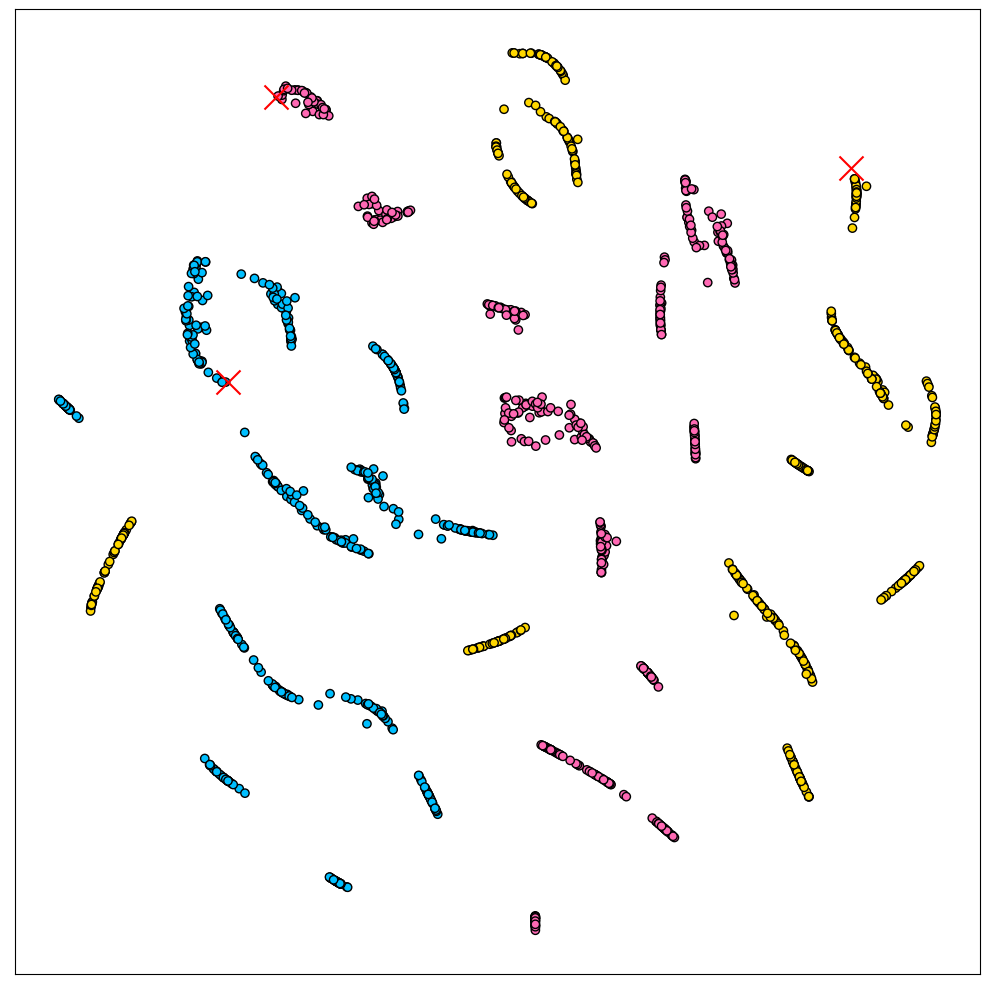

In [10]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.train_autoencoder()

# visualization.makeExcel()
# visualization.makePlot(useTSNE=False)
visualization.plot_tsne()